In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import bisect, newton, toms748

In [2]:
# functions for the numerical integration, put them here in order to compare the fixed points obtained from the two methods
from scipy.integrate import solve_ivp

def cross_in_func(pop,*kwargs):
    # kwargs 
    # first: linear, sigmoid 1 or 2...
    # second: x0
    # third: a
    # fouth: make superior part of the sigmoid linear (True) or not
    if not kwargs or kwargs[0] == 0 or kwargs[0] == 'lin':
        return pop
    elif kwargs[0] == 1 or kwargs[0] == 'sigmoid1':
        x0, a = kwargs[1], kwargs[2]
        cival = 1/(1+np.exp(-a*(pop-x0))) 
        if len(kwargs) == 4 and kwargs[3]:
            cival = min(cival, pop)
        return cival
    elif kwargs[0] == 2 or kwargs[0] == 'sigmoid2':
        x0, a = kwargs[1], kwargs[2]
        return 2*pop/(1+np.exp(-a*(pop-x0)))

def fs_evo_eq(t,fs,pis,qs,l,lci,ci_kwargs=[0, ]):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] #- lci*fs[site_i]*(sum(fs[1:site_i])+sum(fs[site_i+1:]))
        for j in range(len(fs)-1):
            site_j = j+1
            if site_j != site_i:
                dfdt += -lci*fs[site_i]*cross_in_func(fs[site_j],*ci_kwargs)
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

# Linear cross-inhibition

In [3]:
# LINEAR CROSS INHIBITION:
def f0_equation_linci(f0, pis, qs, l, lci, permutation):
    # as a solution of a second degree poly is involved, choose branch by setting +1 or -1
    Nsites = len(pis)
    rs = [1/q for q in qs]
    sumval = 0.0
    for i in range(Nsites):
        sumval += (rs[i] + permutation[i]*np.sqrt(((l+lci)*f0 - rs[i] - lci)**2 - 4*lci*(1-l)*pis[i]*f0))
    sumval = sumval/(2*lci)
    return 1 - f0 + (Nsites*(l+lci)*f0-Nsites*lci)/(2*lci) - sumval

def f0_eq_sqrt_zeros(pi, q, l, lci):
    r = 1/q
    a = (l + lci)**2
    b = (-2*(l+lci)*(r+lci) - 4*lci*(1-l)*pi)
    c = (r+lci)**2
    arrel = np.sqrt(b**2 - 4*a*c)
    return (-b+arrel)/(2*a), (-b-arrel)/(2*a)

def falpha_linci(f0, pi, q, l, lci, branch):
    r = 1/q
    # rootval = np.sqrt(((l+lci)*f0 - r - lci)**2 - 4*lci*(1-l)*pi*f0)
    a = lci
    b = -r-lci+(l+lci)*f0
    c = f0*(1-l)*pi
    arrel = np.sqrt(b**2 - 4*a*c)
    # return (-b+arrel)/(2*a), (-b-arrel)/(2*a)
    return (-b + branch*arrel)/(2*a)

def LSA_matrix(pis, qs, l, lci, sol):
    k = len(pis)
    rows = []
    for i in range(k):
        row_i = []
        for j in range(k):
            if j == i:
                a = l*(sol[0]-sol[i+1]) - (1-l)*pis[i] - 1/qs[i] - lci*(1-sol[0]-3*sol[i+1])
            else:
                a = -(1-l)*pis[i] - l*sol[i+1] + lci*sol[i+1]
            row_i.append(a)
        rows.append(row_i)
    a = np.array(rows)
    return a

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_1415/875865935.py:8: RuntimeWarning: invalid value encountered in sqrt
  sumval += (rs[i] + permutation[i]*np.sqrt(((l+lci)*f0 - rs[i] - lci)**2 - 4*lci*(1-l)*pis[i]*f0))


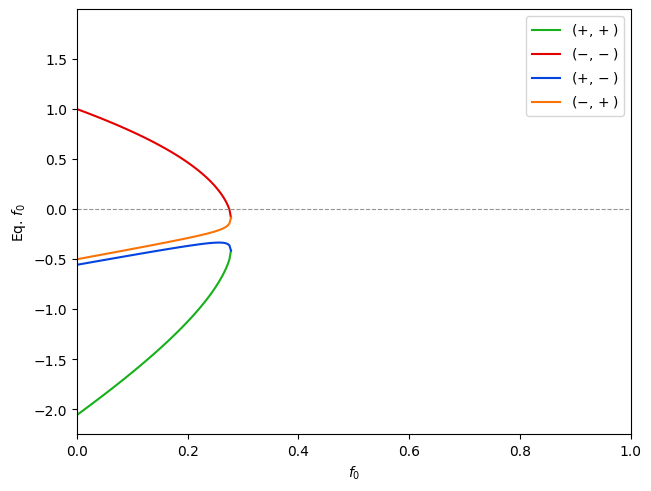

In [5]:
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.6, 0.6
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.3, 0.3
pis, qs, l, lci = [0.2, 0.2], [9.0, 10.0], 0.2, 0.2

f0s1 = f0_eq_sqrt_zeros(pis[0], qs[0], l, lci)
f0s2 = f0_eq_sqrt_zeros(pis[1], qs[1], l, lci)
f0sProb = sorted(f0s1 + f0s2)

f0s_lower = np.linspace(0.0, f0sProb[0], 100)
f0s_upper = np.linspace(f0sProb[-1], 1.0, 100)

permutation = [+1, +1]
eqvals_pp_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_pp_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

permutation = [-1, -1]
eqvals_mm_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_mm_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

permutation = [+1, -1]
eqvals_pm_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_pm_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

permutation = [-1, +1]
eqvals_mp_lower = f0_equation_linci(f0s_lower, pis, qs, l, lci, permutation)
eqvals_mp_upper = f0_equation_linci(f0s_upper, pis, qs, l, lci, permutation)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(f0s_lower, eqvals_pp_lower, color='xkcd:green', label='$(+,+)$')
ax.plot(f0s_upper, eqvals_pp_upper, color='xkcd:green', ls='-.')

ax.plot(f0s_lower, eqvals_mm_lower, color='xkcd:red', label='$(-,-)$')
ax.plot(f0s_upper, eqvals_mm_upper, color='xkcd:red', ls='-.')

ax.plot(f0s_lower, eqvals_pm_lower, color='xkcd:blue', label='$(+,-)$')
ax.plot(f0s_upper, eqvals_pm_upper, color='xkcd:blue', ls='-.')

ax.plot(f0s_lower, eqvals_mp_lower, color='xkcd:orange', label='$(-,+)$')
ax.plot(f0s_upper, eqvals_mp_upper, color='xkcd:orange', ls='-.')

ax.legend()
ax.set(xlabel='$f_0$', ylabel='Eq. $f_0$', xlim=(0.0, 1.0))

ax.axhline(0, 0,1, ls='--', lw=0.8, color='xkcd:gray')
# fig.savefig(f'f0equation_roots_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}_lci_{lci}.png')

In [6]:
permutations = (+1, +1), (+1, -1), (-1, +1), (-1, -1)
sols_f0_perm = {}

for permutation in permutations:
    args = [pis, qs, l, lci, permutation]
    if f0_equation_linci(0.0, *args)*f0_equation_linci(f0sProb[0]-1e-8, *args) < 0:
        a = bisect(f0_equation_linci, 0.0, f0sProb[0], args=(pis, qs, l, lci, permutation))
        sols_f0_perm[permutation] = a

sols_fs_perm = {}
for permutation,f0 in sols_f0_perm.items():
    f1 = falpha_linci(f0, pis[0], qs[0], l, lci, permutation[0])
    f2 = falpha_linci(f0, pis[1], qs[1], l, lci, permutation[1])
    sols_fs_perm[permutation] = [f0, f1, f2]
    

In [53]:
sols_f0_perm

{(1, 1): 0.4015763596721933,
 (1, -1): 0.12347927513484995,
 (-1, 1): 0.11109200175766064}

In [7]:
sols_fs_perm

{(-1, -1): [0.27520743982650464, 0.3225398051873744, 0.40225275499800156]}

In [8]:
# check that solutions add to 1
for v in sols_fs_perm.values():
    print(sum(v))

1.0000000000118805


In [9]:
# LINEAR STABILITY ANALYSIS:
for permutation,sol in sols_fs_perm.items():
    lsa_mat = LSA_matrix(pis, qs, l, lci, sol)
    eigs = np.linalg.eig(lsa_mat)[0]
    print(permutation, eigs)

(-1, -1) [-0.37195189 -0.04907625]


## Lambda evo

In [10]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
pis, qs = [0.2, 0.2], [9.0, 10.0]
# ls = np.arange(0.01, 1.0, 0.01)
ls = np.arange(0.005, 1.0, 0.005)
permutations = (+1, +1), (+1, -1), (-1, +1), (-1, -1)
# permutations = [(+1, -1), ]
   
sols_l_evo_perm = {}
for p in permutations:
    sols_l_evo_perm[p] = {'f0':[], 'f1':[], 'f2':[]}

for l in ls:
    lci = l
    f0s1 = f0_eq_sqrt_zeros(pis[0], qs[0], l, lci)
    f0s2 = f0_eq_sqrt_zeros(pis[1], qs[1], l, lci)
    f0sProb = sorted(f0s1 + f0s2)
    # sols_fs_perm = {}
    for permutation in permutations:
        args = [pis, qs, l, lci, permutation]
        # print(l,permutation)
        try:
            a,b = f0_equation_linci(0.0, *args), f0_equation_linci(f0sProb[0]-1e-8, *args)
        except RuntimeWarning:
            print(permutation, l)
        # if f0_equation_linci(0.0, *args)*f0_equation_linci(f0sProb[0]-1e-6, *args) < 0:
        if a*b < 0:
            f0 = bisect(f0_equation_linci, 0.0, f0sProb[0]-1e-8, args=(pis, qs, l, lci, permutation))
            f1 = falpha_linci(f0, pis[0], qs[0], l, lci, permutation[0])
            f2 = falpha_linci(f0, pis[1], qs[1], l, lci, permutation[1])
            # sols_fs_perm[permutation] = [f0, f1, f2]
            sols_l_evo_perm[permutation]['f0'].append(f0)
            sols_l_evo_perm[permutation]['f1'].append(f1)
            sols_l_evo_perm[permutation]['f2'].append(f2)
        else:
            sols_l_evo_perm[permutation]['f0'].append(float('nan'))
            sols_l_evo_perm[permutation]['f1'].append(float('nan'))
            sols_l_evo_perm[permutation]['f2'].append(float('nan'))

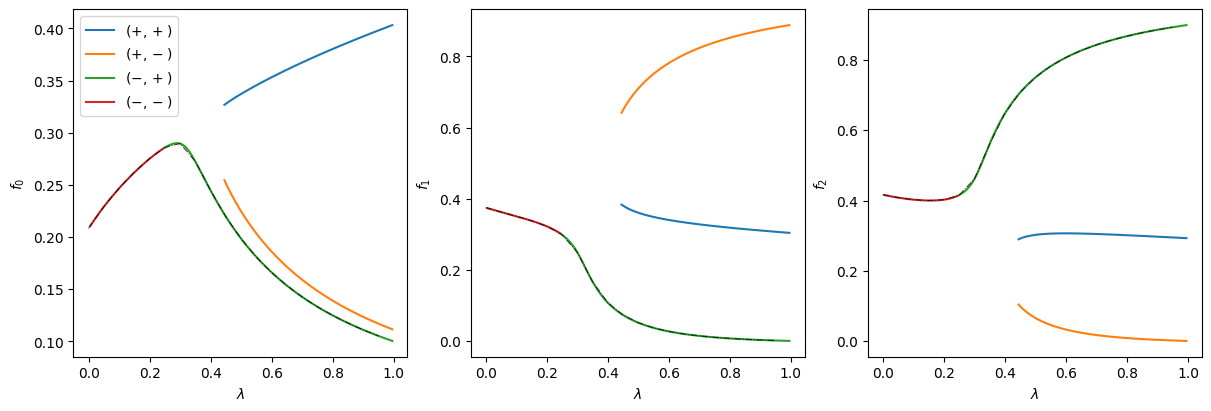

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

for i in range(3):
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

plabels = '$(+,+)$', '$(+,-)$', '$(-,+)$', '$(-,-)$'

for (p,sols),plabel in zip(sols_l_evo_perm.items(),plabels):
    for i in range(3):
        label=plabel if i==0 else '_nolabel_'
        ax[i].plot(ls, sols[f'f{i}'], label=label)
ax[0].legend()

# numerical integration:
plotNumInt = True
if plotNumInt:
    lsNumInt = np.arange(0.0, 1.0, 0.05)
    fs0 = [1.0, 0.0, 0.0]
    l_evo_numint = {'f0':[], 'f1':[], 'f2':[]}
    for l in lsNumInt:
        lci = l
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
        for i in range(3):
            l_evo_numint[f'f{i}'].append(sol.y[i][-1])
    for i in range(3):
        ax[i].plot(lsNumInt, l_evo_numint[f'f{i}'], ls='-.', lw=0.75, color='xkcd:black', alpha=0.75)


fig.savefig(f'lambdaEvo_linci_sols_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_lci_eq_l.png')

## Nonlinear crosss inhibition (2 sites, only one site inhibits)

In [92]:
def f0poly_sols_nlinci(pis, qs, l, lci, winnerSite=2):
    rs = [1/q for q in qs]
    pi1, pi2 = pis
    r1, r2 = rs
    a = -(l**2)
    b = l*(l+lci+r1+r2+(1-l)*(pi1+pi2))
    if winnerSite == 2:
        c = -l*(lci+r1+r2) - (1-l)*(pi1*r2+pi2*r1+pi2*lci) - r1*r2 - r2*lci
        d = r1*r2 + r2*lci
    elif winnerSite == 1:
        c = -l*(lci+r1+r2) - (1-l)*(pi1*r2+pi2*r1+pi1*lci) - r1*r2 - r1*lci
        d = r1*r2 + r1*lci
    elif winnerSite == 3: # the case in which both site are cross inhibiting
        b += l*lci
        c = -(l+lci)*(r1+r2) - (l**2 + lci**2) -l*lci - (1-l)*(pi1*r2+pi2*r1 + lci*(pi1+pi2)) -r1*r2
        d = lci**2 + lci*(r1+r2) + r1*r2
    # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,math.sqrt(-1*radicand0))
        else:
            root0 = complex(math.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, math.sqrt(3))/2
    f0_roots, f0_roots_abs = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        f0_roots.append(f0_root), f0_roots_abs.append(abs(f0_root))
    return f0_roots_abs

def fs_sols_nlinci(f0, pis, qs, l, lci, winnerSite=2):
    rs = [1/q for q in qs]
    if winnerSite == 2:
        f1 = f0*(1-l)*pis[0]/(lci + rs[0] - l*f0)
        f2 = f0*(1-l)*pis[1]/(rs[1] - l*f0)
    elif winnerSite == 1:
        f1 = f0*(1-l)*pis[0]/(rs[0] - l*f0)
        f2 = f0*(1-l)*pis[1]/(lci + rs[1] - l*f0)
    elif winnerSite == 3:
        f1 = f0*(1-l)*pis[0]/(lci + rs[0] - l*f0)
        f2 = f0*(1-l)*pis[1]/(lci + rs[1] - l*f0)
    return f1,f2

In [93]:
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.6, 0.6
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.1, 0.1

# wins f2
f0s = f0poly_sols_nlinci(pis, qs, l, lci)
print(f0s[1], *fs_sols_nlinci(f0s[1], pis, qs, l, lci))

# wins f1
f0s = f0poly_sols_nlinci(pis, qs, l, lci, 1)
print(f0s[1], *fs_sols_nlinci(f0s[1], pis, qs, l, lci, 1))

# both cross inhibit...
f0s = f0poly_sols_nlinci(pis, qs, l, lci, 3)
print(f0s[1], *fs_sols_nlinci(f0s[1], pis, qs, l, lci, 3))

0.3463858856626168 0.1766548653585016 0.47695924897888153
0.3632103970105922 0.4370758727014648 0.1997137302879412
0.4682923137466494 0.2565487338275703 0.27515895242577815


## Lambda evo

In [101]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
ls = np.arange(0.0, 1.0, 0.05)
# ls = np.arange(0.01, 1.0, 0.01)
# ls = np.arange(0.005, 1.0, 0.005)

bounds_wS = 1, 2, 3

# solution when l=lci = 0
s = sum(np.array(pis)*np.array(qs))
f0ci0, f1ci0, f2ci0 = 1/(1+s), pis[0]*qs[0]/(1+s), pis[1]*qs[1]/(1+s)

sols_l_evo_wS = {}
for wS in bounds_wS:
    sols_l_evo_wS[wS] = {'f0':[f0ci0, ], 'f1':[f1ci0, ], 'f2':[f2ci0, ]}

for l in ls[1:]: # exclude l=lci=0
    lci = l
    for wS in bounds_wS:
        f0s = f0poly_sols_nlinci(pis, qs, l, lci, wS)
        f0, f1, f2 = f0s[1], *fs_sols_nlinci(f0s[1], pis, qs, l, lci, wS)
        sols_l_evo_wS[wS]['f0'].append(f0)
        sols_l_evo_wS[wS]['f1'].append(f1)
        sols_l_evo_wS[wS]['f2'].append(f2)

/tmp/ipykernel_55537/2454743526.py:14: RuntimeWarning: overflow encountered in exp
  cival = 1/(1+np.exp(-a*(pop-x0)))


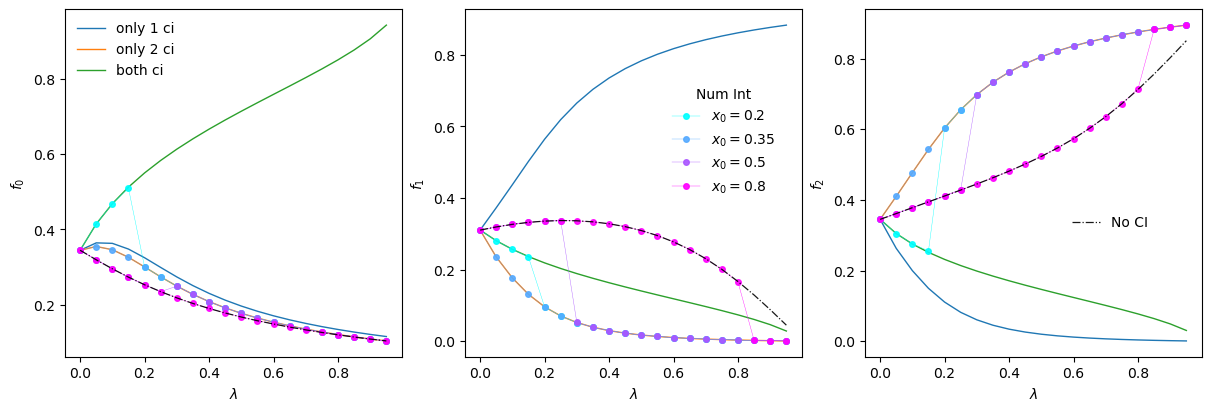

In [110]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

for i in range(3):
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

plabels = 'only 1 ci', 'only 2 ci', 'both ci'

for (wS,sols),wS_label in zip(sols_l_evo_wS.items(),plabels):
    for i in range(3):
        label=wS_label if i==0 else '_nolabel_'
        ax[i].plot(ls, sols[f'f{i}'], label=label, lw=1.0, alpha=1.0)
ax[0].legend(frameon=False)

# numerical integration:
plotNumInt = True
if plotNumInt:
    lsNumInt = np.arange(0.0, 1.0, 0.05)
    fs0 = [1.0, 0.0, 0.0]
    a = 100
    x0s = [0.2, 0.35, 0.5, 0.8]
    colors = plt.cm.cool(np.linspace(0,1,len(x0s)))
    for x0,c in zip(x0s,colors):
        l_evo_numint = {'f0':[], 'f1':[], 'f2':[]}
        for l in lsNumInt:
            lci = l
            sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, [1, x0, a, 0]))
            for i in range(3):
                l_evo_numint[f'f{i}'].append(sol.y[i][-1])
        for i in range(3):
            # ax[i].plot(lsNumInt, l_evo_numint[f'f{i}'], ls='-.', lw=0.75, color=c, alpha=0.75)
            label=f'$x_0 = {x0}$' if i==1 else '_nolabel_'
            ax[i].plot(lsNumInt, l_evo_numint[f'f{i}'], lw=0.3, marker='.', ms=8, color=c, alpha=0.9, label=label)
    # no cross inhibition:
    l_evo_numint = {'f0':[], 'f1':[], 'f2':[]}
    for l in lsNumInt:
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, 0.0))
        for i in range(3):
            l_evo_numint[f'f{i}'].append(sol.y[i][-1])
    for i in range(3):
        label=f'No CI' if i==2 else '_nolabel_'
        ax[i].plot(lsNumInt, l_evo_numint[f'f{i}'], lw=0.9, ls='-.', color='k', alpha=0.9, label=label)
        

ax[1].legend(title='Num Int', frameon=False, loc=(0.6,0.45))
ax[2].legend(frameon=False, loc=(0.6,0.35))

fig.savefig(f'lambdaEvo_sig1ci_sols_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_lci_eq_l.png')